In [15]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from pathlib import Path
from torch.optim.sgd import SGD
from google.colab import userdata

# Set up repo
password_github = userdata.get('password-github')

!git config --global user.name "Shahid0120"
!git config --global user.email "shahid.hussain0120@gmail.com"
!git config --global user.password password_github

token = userdata.get('github-token')
username = 'Shahid0120'
repo='atlassian-allianz-neural-network'

!git clone https://{token}@github.com/{username}/{repo}


Cloning into 'atlassian-allianz-neural-network'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 10), reused 29 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 470.41 KiB | 2.29 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [16]:
from sklearn.model_selection import train_test_split

# Loading Data
dataPath = './atlassian-allianz-neural-network/data/01_encoded_no_transformations/01_encoded_no_transformations.csv'
data = pd.read_csv(dataPath)

X = data.drop(columns=['fraud_reported'])
Y = data['fraud_reported']

# Turn Data into Tensors

# X/Y is initally a DataFrame
X_ndarray = X.to_numpy()
Y_ndarray = Y.to_numpy()

# Convert to Tensor
X = torch.from_numpy(X_ndarray).type(torch.float)
Y = torch.from_numpy(Y_ndarray)

# Split Tensors into Train and Test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size = 0.1,
    random_state=42
)

len(X_train), len(X_test), len(Y_train), len(Y_test)

(2667, 297, 2667, 297)

In [17]:
device = "cpu"

# Model
class FraudModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_01 = nn.Linear(in_features=124, out_features=10)  # First layer
    self.layer_02 = nn.Linear(in_features=10, out_features=1)  # Second layer
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # return logit
    return self.layer_02(self.relu(self.layer_01(x)))


model_1 = FraudModelV1()
model_1


FraudModelV1(
  (layer_01): Linear(in_features=124, out_features=10, bias=True)
  (layer_02): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

Epoch 0 | Train Loss: 0.7052 | Train Accuracy: 50.51 | Test Loss: 0.7227 | Test Accuracy: 43.43
Epoch 10000 | Train Loss: 0.2056 | Train Accuracy: 92.39 | Test Loss: 0.2251 | Test Accuracy: 91.58
Epoch 20000 | Train Loss: 0.1911 | Train Accuracy: 93.55 | Test Loss: 0.2191 | Test Accuracy: 92.93
Epoch 30000 | Train Loss: 0.1809 | Train Accuracy: 93.89 | Test Loss: 0.2154 | Test Accuracy: 93.27
Epoch 40000 | Train Loss: 0.1672 | Train Accuracy: 94.23 | Test Loss: 0.2143 | Test Accuracy: 93.94
Epoch 50000 | Train Loss: 0.1500 | Train Accuracy: 94.45 | Test Loss: 0.2156 | Test Accuracy: 93.94
Epoch 60000 | Train Loss: 0.1338 | Train Accuracy: 95.05 | Test Loss: 0.2195 | Test Accuracy: 94.28
Epoch 70000 | Train Loss: 0.1198 | Train Accuracy: 95.65 | Test Loss: 0.2242 | Test Accuracy: 94.28
Epoch 80000 | Train Loss: 0.1096 | Train Accuracy: 95.91 | Test Loss: 0.2327 | Test Accuracy: 93.60
Epoch 90000 | Train Loss: 0.1016 | Train Accuracy: 96.29 | Test Loss: 0.2425 | Test Accuracy: 93.60


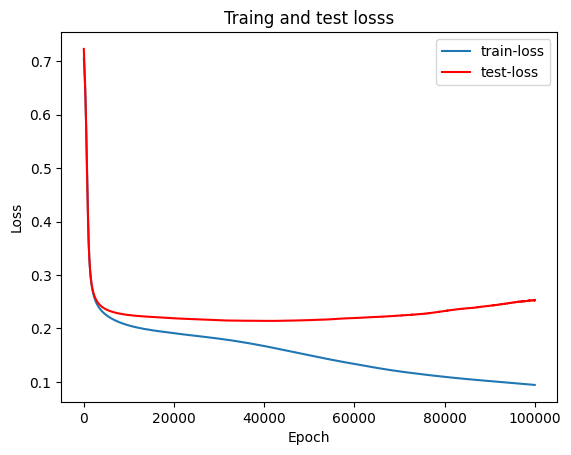

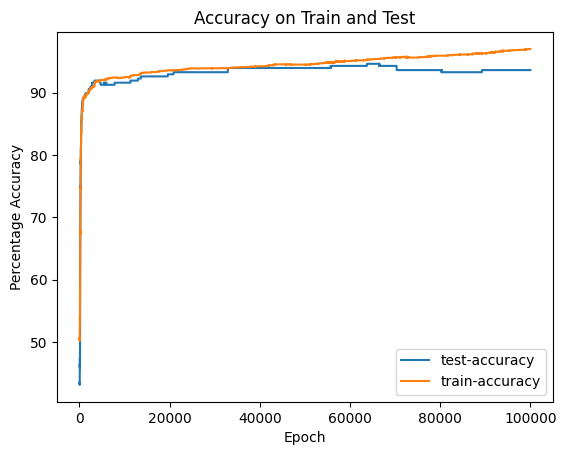

In [18]:
# loss function and gradient descent algorithm
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation inside
optimizer  = SGD(params=model_1.parameters(), lr=0.01)

# Calculate Accuracy
def accuracy(y_true, y_pred):
  sum_correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (sum_correct / len(y_pred)) * 100
  return accuracy

# Put into right device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

epochs = 100000

test_loss_arr = []
train_loss_arr = []
test_acuracy_arr = []
train_acuracy_arr = []

for epoch in range(epochs):
    # Train model
    model_1.train()

    # Forward pass
    Y_logits = model_1(X_train).squeeze()
    Y_probs = torch.round(torch.sigmoid(Y_logits))

    # Compute loss and accuracy for training
    loss = loss_fn(Y_logits, Y_train)
    train_loss_arr.append(loss.item())
    accuracy_train = accuracy(Y_train, Y_probs)
    train_acuracy_arr.append(accuracy_train)
    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Step the optimizer
    optimizer.step()

    # Set the model to evaluation mode
    model_1.eval()

    # Inference on test data
    with torch.inference_mode():
        Y_test_logits = model_1(X_test).squeeze()
        Y_test_probs = torch.round(torch.sigmoid(Y_test_logits))

        # Compute loss and accuracy for testing
        test_loss = loss_fn(Y_test_logits, Y_test)
        test_loss_arr.append(test_loss.item())
        accuracy_test = accuracy(Y_test, Y_test_probs)
        test_acuracy_arr.append(accuracy_test)

    # Print results at each epoch
    if epoch % 10000 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Train Accuracy: {accuracy_train:.2f} | Test Loss: {test_loss.item():.4f} | Test Accuracy: {accuracy_test:.2f}")

plt.figure(1)
plt.plot(np.arange(epochs), train_loss_arr, label='train-loss')
plt.plot(np.arange(epochs), test_loss_arr, label='test-loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Traing and test losss")
plt.legend()
plt.show()

plt.figure(2)
plt.plot(np.arange(epochs), test_acuracy_arr, label='test-accuracy')
plt.plot(np.arange(epochs), train_acuracy_arr, label='train-accuracy')
plt.xlabel("Epoch")
plt.ylabel("Percentage Accuracy")
plt.title("Accuracy on Train and Test")
plt.legend()
plt.show()

In [19]:
test_max_accuracy = np.max(test_acuracy_arr)
train_max_accuracy = np.max(train_acuracy_arr)

print(f"The highest test accuracy for Epoch : {epochs} was test : {test_max_accuracy} and train : {train_max_accuracy}")

The highest test accuracy for Epoch : 100000 was test : 94.61279461279462 and train : 97.00037495313086


Clearly from a linear Model with 2 layer NN out best perofrmacne was arounf 4000 epochs with 93% accuracy on test set and 94% training samples

In this with 1 added hiden unit and a nonlinear acitivation ReLu in first hidden layer we get
94% on test a slight imporvement but our training accuracy goes to 99% which is clearly overfitting the training samples.Thus to we have high Variance problem so to rectify i will implement and compare
- Regulisation : L1, L2, dropout regulisation

Note: Overfitting starts occuring around the 30,000 ipochs range

In [22]:
# Create a function for training

def model(model, X_train, Y_train, X_test, Y_test, epochs=10000, device="cpu", weight_decay=0.0):

  # Initialize arrays
  test_loss_arr = []
  train_loss_arr = []
  test_accuracy_arr = []
  train_accuracy_arr = []

  # loss function and gradient descent algorithm
  loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation inside
  optimizer  = SGD(params=model_1.parameters(), lr=0.01, weight_decay=weight_decay)

  # Calculate Accuracy
  def accuracy(y_true, y_pred):
    sum_correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (sum_correct / len(y_pred)) * 100
    return accuracy

  # Put into right device
  X_train, Y_train = X_train.to(device), Y_train.to(device)
  X_test, Y_test = X_test.to(device), Y_test.to(device)

  # training loop
  for epoch in range(epochs):
      # Train model
      model_1.train()

      # Forward pass
      Y_logits = model_1(X_train).squeeze()
      Y_probs = torch.round(torch.sigmoid(Y_logits))

      # Compute loss and accuracy for training
      loss = loss_fn(Y_logits, Y_train)
      train_loss_arr.append(loss.item())
      accuracy_train = accuracy(Y_train, Y_probs)
      train_accuracy_arr.append(accuracy_train)

      # Zero the gradients
      optimizer.zero_grad()

      # Backward pass
      loss.backward()

      # Step the optimizer
      optimizer.step()

      # Set the model to evaluation mode
      model_1.eval()

      # Inference on test data
      with torch.inference_mode():
          Y_test_logits = model_1(X_test).squeeze()
          Y_test_probs = torch.round(torch.sigmoid(Y_test_logits))

          # Compute loss and accuracy for testing
          test_loss = loss_fn(Y_test_logits, Y_test)
          test_loss_arr.append(test_loss.item())
          accuracy_test = accuracy(Y_test, Y_test_probs)
          test_accuracy_arr.append(accuracy_test)

      # Print results at each epoch
      if epoch % 10000 == 0:
          print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Train Accuracy: {accuracy_train:.2f} | Test Loss: {test_loss.item():.4f} | Test Accuracy: {accuracy_test:.2f}")

  return test_loss_arr, train_loss_arr, test_accuracy_arr, train_accuracy_arr

def plot_loss_functions(test_loss_arr_l2, train_loss_arr_l2, test_accuracy_arr_l2, train_accuracy_arr_l2, epochs=2):
  plt.figure(1)
  plt.plot(np.arange(epochs), train_loss_arr_l2, label='train-loss')
  plt.plot(np.arange(epochs), test_loss_arr_l2, label='test-loss', color='red')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Traing and test losss")
  plt.legend()
  plt.show()

  plt.figure(2)
  plt.plot(np.arange(len(test_accuracy_arr_l2)), test_accuracy_arr_l2, label='test-accuracy')
  plt.plot(np.arange(len(train_accuracy_arr_l2)), train_accuracy_arr_l2, label='train-accuracy')
  plt.xlabel("Epoch")
  plt.ylabel("Percentage Accuracy")
  plt.title("Accuracy on Train and Test")
  plt.legend()
  plt.show()

  return


# L2 regulisation

Epoch 0 | Train Loss: 0.0945 | Train Accuracy: 97.00 | Test Loss: 0.2526 | Test Accuracy: 93.60
Epoch 10000 | Train Loss: 0.3877 | Train Accuracy: 90.29 | Test Loss: 0.3867 | Test Accuracy: 90.24
Epoch 20000 | Train Loss: 0.3878 | Train Accuracy: 90.29 | Test Loss: 0.3867 | Test Accuracy: 90.24
Epoch 30000 | Train Loss: 0.3878 | Train Accuracy: 90.29 | Test Loss: 0.3867 | Test Accuracy: 90.24


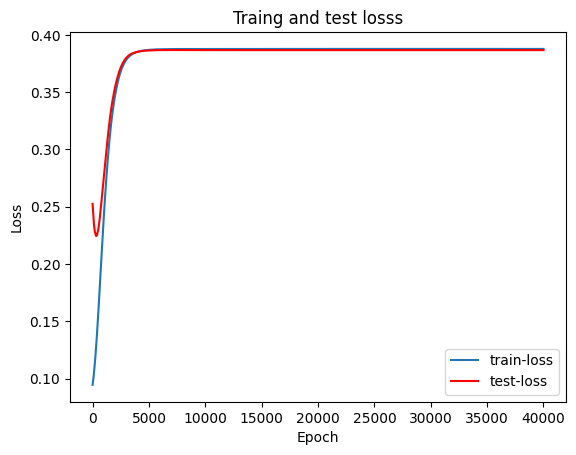

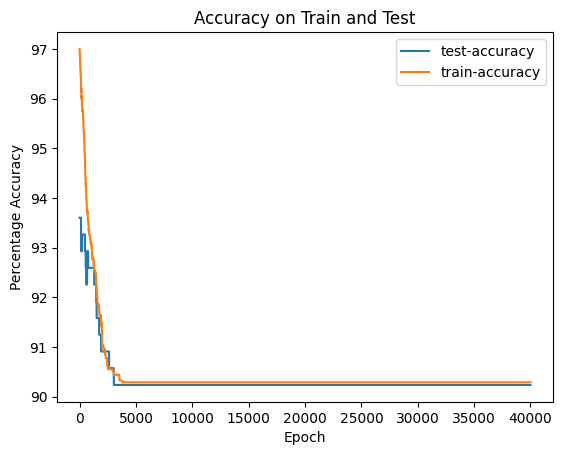

In [23]:
# L2 regulisation
test_loss_arr_l2, train_loss_arr_l2, test_accuracy_arr_l2, train_accuracy_arr_l2 = model(model, X_train, Y_train, X_test, Y_test, epochs=40000, device="cpu", weight_decay=0.1)
plot_loss_functions(test_loss_arr_l2, train_loss_arr_l2, test_accuracy_arr_l2, train_accuracy_arr_l2, epochs=40000)

Epoch 0 | Train Loss: 0.3878 | Train Accuracy: 90.29 | Test Loss: 0.3864 | Test Accuracy: 90.24
Epoch 10000 | Train Loss: 0.2268 | Train Accuracy: 92.28 | Test Loss: 0.2403 | Test Accuracy: 91.92
Epoch 20000 | Train Loss: 0.2234 | Train Accuracy: 92.39 | Test Loss: 0.2385 | Test Accuracy: 92.26
Epoch 30000 | Train Loss: 0.2227 | Train Accuracy: 92.39 | Test Loss: 0.2382 | Test Accuracy: 91.92
Epoch 40000 | Train Loss: 0.2224 | Train Accuracy: 92.39 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 50000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 60000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 70000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 80000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 90000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92


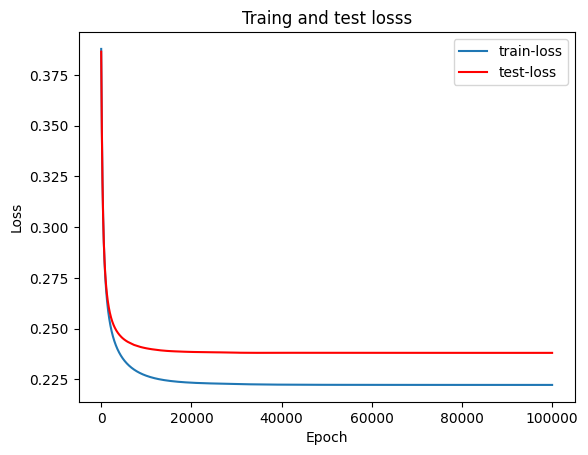

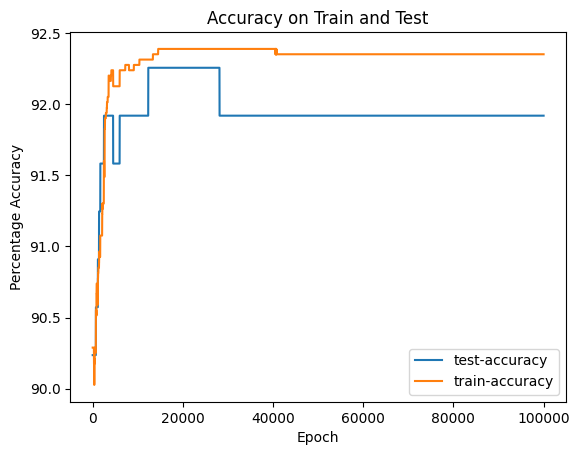

The highest test accuracy for Epoch : 100000 was test : 92.25589225589226 and train : 92.38845144356955


In [24]:
# L2 - 0.01
test_loss_arr_l2, train_loss_arr_l2, test_accuracy_arr_l2, train_accuracy_arr_l2 = model(model, X_train, Y_train, X_test, Y_test, epochs=100000, device="cpu", weight_decay=0.01)
plot_loss_functions(test_loss_arr_l2, train_loss_arr_l2, test_accuracy_arr_l2, train_accuracy_arr_l2, epochs=100000)

test_max_accuracy_l2 = np.max(test_accuracy_arr_l2)
train_max_accuracy_l2 = np.max(train_accuracy_arr_l2)

print(f"The highest test accuracy for Epoch : {100000} was test : {test_max_accuracy_l2} and train : {train_max_accuracy_l2}")

In [25]:
# Fixing Bias problem by adding layer for L2 regulisation
class FraudModelV1V1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_01 = nn.Linear(in_features=124, out_features=10)  # First layer
    self.layer_02 = nn.Linear(in_features=10, out_features=10)  # Second layer
    self.layer_03 = nn.Linear(in_features=10, out_features=1)  # Third layer
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # return logit
    return self.layer_03(self.relu(self.layer_02(self.relu(self.layer_01(x)))))

model_01_01 = FraudModelV1V1()
model_01_01

FraudModelV1V1(
  (layer_01): Linear(in_features=124, out_features=10, bias=True)
  (layer_02): Linear(in_features=10, out_features=10, bias=True)
  (layer_03): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

Epoch 0 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 10000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 20000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 30000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 40000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 50000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 60000 | Train Loss: 0.2223 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 70000 | Train Loss: 0.2222 | Train Accuracy: 92.35 | Test Loss: 0.2381 | Test Accuracy: 91.92
Epoch 80000 | Train Loss: 0.2222 | Train Accuracy: 92.35 | Test Loss: 0.2380 | Test Accuracy: 91.92
Epoch 90000 | Train Loss: 0.2222 | Train Accuracy: 92.35 | Test Loss: 0.2380 | Test Accuracy: 91.92


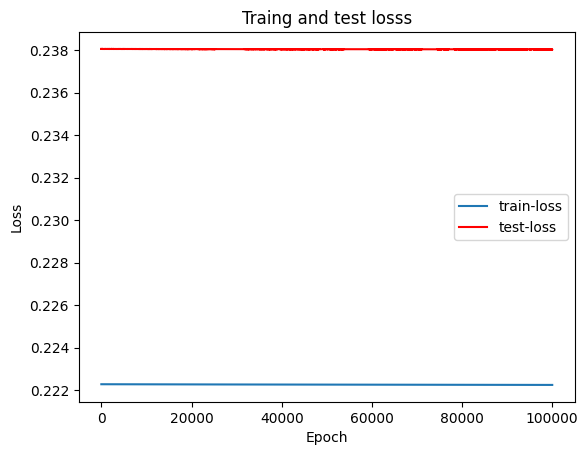

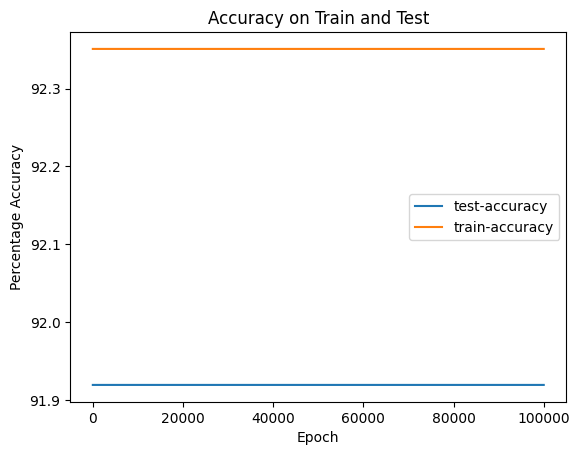

The highest test accuracy for Epoch : 100000 was test : 91.91919191919192 and train : 92.35095613048368


In [26]:
# L2 0.01 with added hiden layer
test_loss_arr_l2, train_loss_arr_l2, test_accuracy_arr_l2, train_accuracy_arr_l2 = model(model_01_01, X_train, Y_train, X_test, Y_test, epochs=100000, device="cpu", weight_decay=0.01)
plot_loss_functions(test_loss_arr_l2, train_loss_arr_l2, test_accuracy_arr_l2, train_accuracy_arr_l2, epochs=100000)

test_max_accuracy_l2 = np.max(test_accuracy_arr_l2)
train_max_accuracy_l2 = np.max(train_accuracy_arr_l2)

print(f"The highest test accuracy for Epoch : {100000} was test : {test_max_accuracy_l2} and train : {train_max_accuracy_l2}")

In [27]:
%cd
%cd /content/atlassian-allianz-neural-network

/root
/content/atlassian-allianz-neural-network


In [28]:
%ls

01_model_encoded_no_transformations_data_FNN.ipynb  data/  experiments/  README.md
atlassian-allianz-neural-network/                   EDA/   models/       reports/


In [30]:
from pathlib import Path

FODLER_PATH = Path('/content/atlassian-allianz-neural-network/models/model_1_relu_nn')
FILE_NAME = '01-model-encoded-no-transformations-data-FNN-activiation-relu-2-layer.pth'
MODEL_PATH = FODLER_PATH / FILE_NAME

torch.save(obj=model_1, f=MODEL_PATH)

MODEL_NAME_REGULISATION = '01-model-encoded-no-transformations-data-FNN-activiation-relu-2-layer-l2-regulisation.pth'
MODEL_PATH_TWO = FODLER_PATH / MODEL_NAME_REGULISATION

torch.save(obj=model_01_01, f=MODEL_PATH_TWO)


In [31]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	atlassian-allianz-neural-network/
	models/model_1_relu_nn/

nothing added to commit but untracked files present (use "git add" to track)


In [33]:
%ls

01_model_encoded_no_transformations_data_FNN.ipynb  data/  experiments/  README.md
atlassian-allianz-neural-network/                   EDA/   models/       reports/


In [34]:
!git add .

In [36]:
!rm -rf /content/atlassian-allianz-neural-network/atlassian-allianz-neural-network

In [37]:
!git add .

In [38]:
!git commit -m 'Create a 2 layer NN using a relu acitivation function in hiden layer. Created a 3 layer NN using a relu activiation function in both hidden layers. Experimented with L2 regulisation to reduce variance'

[main 925fbe8] Create a 2 layer NN using a relu acitivation function in hiden layer. Created a 3 layer NN using a relu activiation function in both hidden layers. Experimented with L2 regulisation to reduce variance
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 models/model_1_relu_nn/01-model-encoded-no-transformations-data-FNN-activiation-relu-2-layer-l2-regulisation.pth
 create mode 100644 models/model_1_relu_nn/01-model-encoded-no-transformations-data-FNN-activiation-relu-2-layer.pth


In [39]:
!git push

Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 13.51 KiB | 13.51 MiB/s, done.
Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/Shahid0120/atlassian-allianz-neural-network
   6d62263..925fbe8  main -> main


In [42]:
%cd ..

/


In [43]:
%ls

bin@                        datalab/  lib@     media/                    proc/        sbin@  tools/
boot/                       dev/      lib32@   mnt/                      python-apt/  srv/   usr/
content/                    etc/      lib64@   NGC-DL-CONTAINER-LICENSE  root/        sys/   var/
cuda-keyring_1.0-1_all.deb  home/     libx32@  opt/                      run/         tmp/


In [44]:
%cd content

/content


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
%ls


atlassian-allianz-neural-network/  drive/  sample_data/
